# StableDiffusionで生成した画像から3Dモデルを"AIで"作成し、キャラクターを動かす
REF: [StableDiffusionで生成した画像から3Dモデルを"AIで"作成し、Unity上でキャラクターを動かすまで【CSM AIの使い方】](https://note.com/okp_/n/n89b96384e0cb?sub_rt=share_b)

### StableDiffusionからモデルの作成

In [1]:
from diffusers import StableDiffusionPipeline, UniPCMultistepScheduler
import torch
import os
import random

def run_stable_diffusion(prompt,
                         output_filename, 
                         device="mps"):
    seed = random.randint(1, 9999)
    print(f"Seed: {seed}")

    # REF: https://civitai.com/models/93028
    safetensor_path = "./safetensors/kidsmix_v10.safetensors"
    pipe = StableDiffusionPipeline.from_single_file(safetensor_path, torch_dtype=torch.float32).to(device)

    pipe.vae.enable_tiling()

    negative_prompt = "EasyNegative, no_humans ,painting ,sketches ,(low quality, worst quality:1.5) ,deformed ,bad anatomy ,lowres ,monochrome ,grayscale ,ugly face ,half-open eyes ,deformed eyes ,open mouth ,long body ,inaccurate limb ,bad hands ,mutated hands ,mutated legs ,missing fingers ,extra fingers ,extra arms ,text ,error ,cropped ,jpeg artifacts ,signature ,watermark ,username ,artist name ,out of focus ,make-up ,(mascara)1.4 ,rouge ,face paint"
    generator = torch.Generator(device).manual_seed(seed)

    image = pipe(prompt, negative_prompt=negative_prompt, num_inference_steps=30, generator=generator).images[0]
    os.makedirs(os.path.dirname(output_filename), exist_ok=True)
    image.save(output_filename)

/Users/yoshino/src/github.com/yoshino/stable-diffusion-mps-notes/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ポイントは"concept art, official art,full body,T-pose"のプロンプト。これらを含めることで、T-poseじみたものが出るようになる。
prompt = "masterpiece,best quality,virtual youtuber, toddler, ((concept art, official art,full body)), simple background,(children under 10 years old:1.2),standing,solo,(T-pose:1.2)"

Seed: 8170


`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
/Users/yoshino/src/github.com/yoshino/stable-diffusion-mps-notes/.venv/lib/python3.11/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
100%|██████████| 30/30 [00:11<00:00,  2.56it/s]


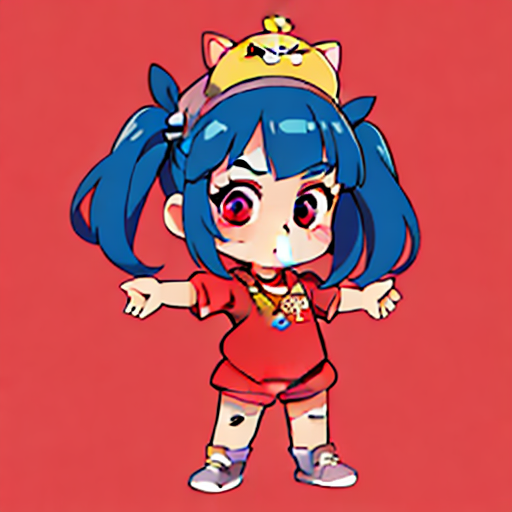

In [3]:
from PIL import Image

output_file_path = "./output/stable-diffusion-to-3d-model.png"
run_stable_diffusion(prompt, output_file_path)
Image.open(output_file_path)

In [4]:
def run_stable_diffusion_with_easy_negative(prompt, output_filename, device="mps"):
    seed = random.randint(1, 9999)
    print(f"Seed: {seed}")

    # REF: https://civitai.com/models/93028
    safetensor_path = "./safetensors/kidsmix_v10.safetensors"
    pipe = StableDiffusionPipeline.from_single_file(safetensor_path, torch_dtype=torch.float32).to(device)

    # safety checker を無効にする
    # REF: https://hackmd.io/@kivantium/HyMlKoyXj
    def null_safety(images, **kwargs):
        return images, False

    pipe.safety_checker = null_safety

    text_inversion_safetensor_path = "./safetensors/EasyNegativeV2.safetensors"
    pipe.load_textual_inversion("EasyNegative-test", weight_name=text_inversion_safetensor_path, token="EasyNegative")

    pipe.vae.enable_tiling()

    negative_prompt = "EasyNegative, no_humans ,painting ,sketches ,(low quality, worst quality:1.5) ,deformed ,bad anatomy ,lowres ,monochrome ,grayscale ,ugly face ,half-open eyes ,deformed eyes ,open mouth ,long body ,inaccurate limb ,bad hands ,mutated hands ,mutated legs ,missing fingers ,extra fingers ,extra arms ,text ,error ,cropped ,jpeg artifacts ,signature ,watermark ,username ,artist name ,out of focus ,make-up ,(mascara)1.4 ,rouge ,face paint"
    generator = torch.Generator(device).manual_seed(seed)

    image = pipe(prompt, negative_prompt=negative_prompt, num_inference_steps=30, generator=generator).images[0]
    os.makedirs(os.path.dirname(output_filename), exist_ok=True)
    image.save(output_filename)

Seed: 4929


`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
100%|██████████| 30/30 [00:11<00:00,  2.50it/s]


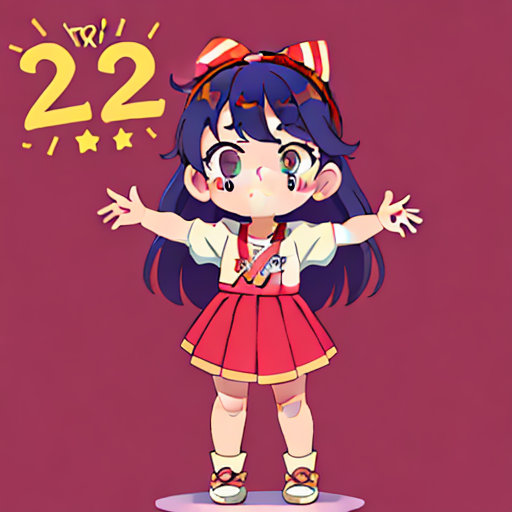

In [5]:
output_file_path = "./output/stable-diffusion-to-3d-model-with-easy-negative.png"
run_stable_diffusion(prompt, output_file_path)
Image.open(output_file_path)

### ControlNet

#### ControlNetがMacで動くかの確認
REF: https://github.com/koshian2/ai-art-book/tree/master

In [6]:
def load_resize(path):
    img = Image.open(path)
    if img.width > img.height:
        height = 512
        width = int((img.width / img.height * 512) // 8 * 8)
    else:
        width = 512
        height = int((img.height / img.width * 512) // 8 * 8)
    img = img.resize((width, height), Image.Resampling.BICUBIC)
    return img

In [7]:
from controlnet_aux import OpenposeDetector
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel

def run_control_net(device="mps"):
  pose = OpenposeDetector.from_pretrained('lllyasviel/ControlNet')
  original_img = load_resize("./data/t-pose.png")
  condition_img = pose(original_img)
  
  prompt = "best quality, extremely detailed"
  negative_prompt = "longbody, lowres, bad anatomy, bad hands, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality"    
  
  controlnet_models =  ["lllyasviel/sd-controlnet-openpose", "lllyasviel/control_v11p_sd15_openpose"]
  controlnet = ControlNetModel.from_pretrained(controlnet_models[0]).to(device)

  models = ["runwayml/stable-diffusion-v1-5", "NoCrypt/SomethingV2_2"]
  pipe = StableDiffusionControlNetPipeline.from_pretrained(
    models[0], controlnet=controlnet, safety_checker=None
  ).to(device)

  generator = torch.Generator(device).manual_seed(1234)
  image = pipe(prompt, negative_prompt=negative_prompt, 
               num_inference_steps=30, generator=generator, image=condition_img).images[0]

  return [original_img, condition_img, image]

/Users/yoshino/src/github.com/yoshino/stable-diffusion-mps-notes/.venv/lib/python3.11/site-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(


In [8]:
results = run_control_net()

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
Loading pipeline components...: 100%|██████████| 6/6 [00:04<00:00,  1.22it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the p

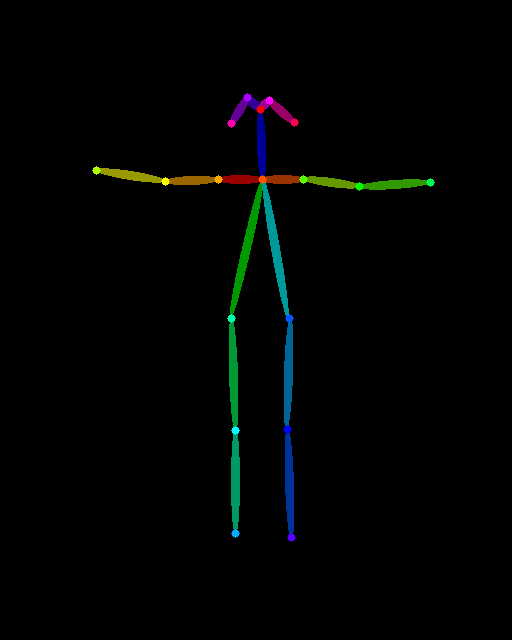

In [9]:
results[1]

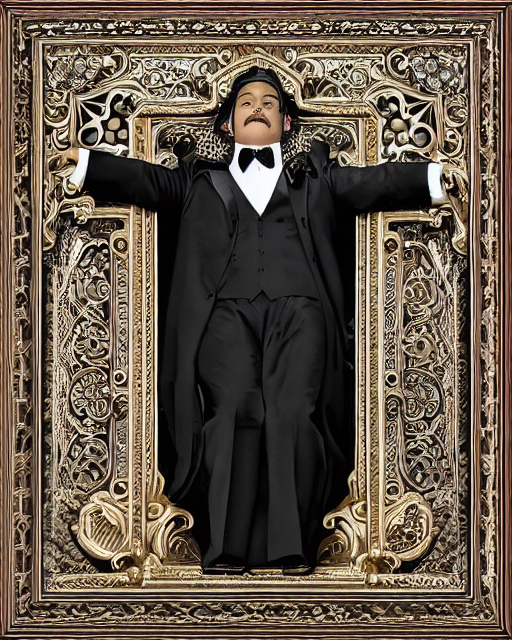

In [10]:
results[2]

#### ControlNet + Model from Checkpoint + Easy Negative

In [26]:
from controlnet_aux import OpenposeDetector
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
from PIL import Image
import torch

def run_control_net(device="mps"):
  pose = OpenposeDetector.from_pretrained('lllyasviel/ControlNet')
  original_img = load_resize("./data/t-pose.png")
  condition_img = pose(original_img)
  
  prompt = "masterpiece,best quality,virtual youtuber, toddler, ((concept art, official art,full body)), simple background,(children under 10 years old:1.2),standing,solo,(T-pose:1.2)"
  negative_prompt = "EasyNegative, no_humans ,painting ,sketches ,(low quality, worst quality:1.5) ,deformed ,bad anatomy ,lowres ,monochrome ,grayscale ,ugly face ,half-open eyes ,deformed eyes ,open mouth ,long body ,inaccurate limb ,bad hands ,mutated hands ,mutated legs ,missing fingers ,extra fingers ,extra arms ,text ,error ,cropped ,jpeg artifacts ,signature ,watermark ,username ,artist name ,out of focus ,make-up ,(mascara)1.4 ,rouge ,face paint"
  
  controlnet_models =  ["lllyasviel/sd-controlnet-openpose", "lllyasviel/control_v11p_sd15_openpose"]
  controlnet = ControlNetModel.from_pretrained(controlnet_models[0]).to(device)

  safetensor_path = "./safetensors/kidsmix_v10.safetensors"
  pipe = StableDiffusionControlNetPipeline.from_single_file(
    safetensor_path, torch_dtype=torch.float32,
    controlnet=controlnet, safety_checker=None
  ).to(device)

  # REF: https://note.com/yossymura/n/n64b421ffd927
  # 引数のして方法を参考にした
  text_inversion_safetensor_path = "EasyNegativeV2.safetensors"
  pipe.load_textual_inversion("./safetensors", weight_name=text_inversion_safetensor_path, token="EasyNegative")

  pipe.vae.enable_tiling()


  seed = random.randint(1, 9999)
  print(f"Seed: {seed}")
  generator = torch.Generator(device).manual_seed(seed)
  image = pipe(prompt, negative_prompt=negative_prompt, 
               num_inference_steps=30, generator=generator, image=condition_img).images[0]

  return [original_img, condition_img, image]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 49424. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosi

Seed: 1881


100%|██████████| 30/30 [00:22<00:00,  1.33it/s]


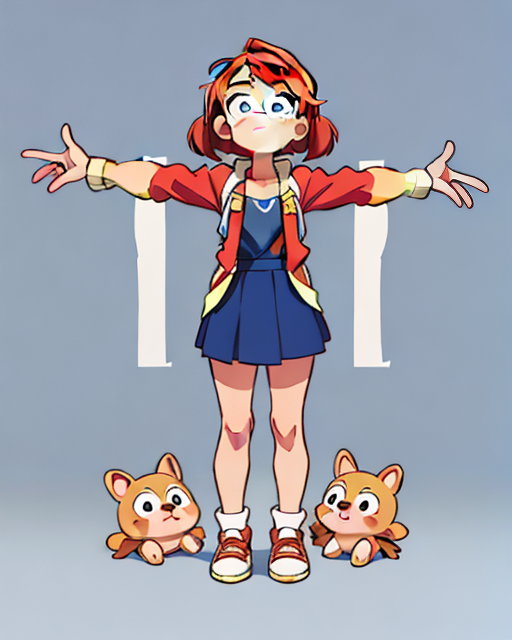

In [27]:
results = run_control_net()
results[2].save('./data/model-with-background.png')
results[2]

### 背景画像を綺麗にする
REF: https://zenn.dev/wurly/articles/84139635819f82

In [28]:
from rembg import remove

input_path = './data/model-with-background.png'
output_path = './data//model-without-background.png'

input = Image.open(input_path)
output = remove(input)
output.save(output_path)

### 「CSM.AI」で3Dモデル作成
- csm.ai: https://www.csm.ai/
- 作成したモデル: https://3d.csm.ai/detail/SESSION_1695384153_4703969
    - 2時間くらいかかるらしい
    - 無料プランだと作成されたモデルが公開された状態になる
    - Downloads > Refined Mesh > OBJ でダウンロードする

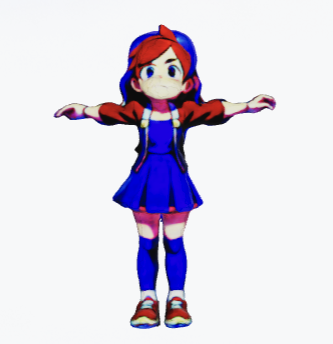

In [6]:
Image('./output/csm-result.png')

### 3D モデルをsharpEで作成する
今回の人のモデルのようなものは厳しいみたい(CSMすごい)。

REF: https://colab.research.google.com/drive/1AIF6Py0BK3DFosF2BJap0eZF0OYpc2q0?usp=sharing

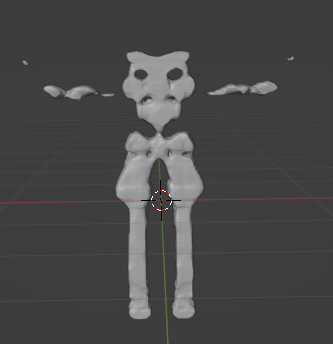

In [5]:
Image('./output/shape-result.png')

### 「Mixamo」でアニメーションの設定
- ダウンロードしたOBJ(zip)をそのまま、Mixamoにアップロードして、リギングの設定 -> アニメーションの選択して、fbx形式でダウンロードする
- REF: https://note.com/nakashun_t/n/n33a3c0a99876
- REF2: [.mov を gif に変換【Mac】](https://qiita.com/ntkgcj/items/6ac08a007f24a2de0b36)

In [3]:
from IPython.display import Image
Image(url='./output/dance.gif')